# Feature Engineering

## 1. Baseline ML-Model

In [69]:
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from scipy import stats
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_score, accuracy_score

In [70]:
# path to the data on the local machine
path = "/Users/maximkiesel/Desktop/Master/Model Engineering/feature_engineering.xlsx"

In [71]:
# load the data
df = pd.read_excel(path)

In [72]:
# split data in X and y
y = df['success']
X = df.drop('success', axis=1)

In [73]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# Create the Random Forest Classifier with some arbitrary parameters
rfc = RandomForestClassifier()

In [75]:
# Train the model
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
# Perform cross-validation on the training set using precision as the scoring metric
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='f1_weighted')

In [77]:
# Print out the cross-validation scores
print("Baseline model cross-validation scores: ", cv_scores)
print("Baseline model mean cross-validation score: ", np.mean(cv_scores))

Baseline model cross-validation scores:  [0.71542547 0.71291732 0.70568707 0.71259151 0.71348627]
Baseline model mean cross-validation score:  0.7120215292625677


In [78]:
# Get feature importances
importances = rfc.feature_importances_

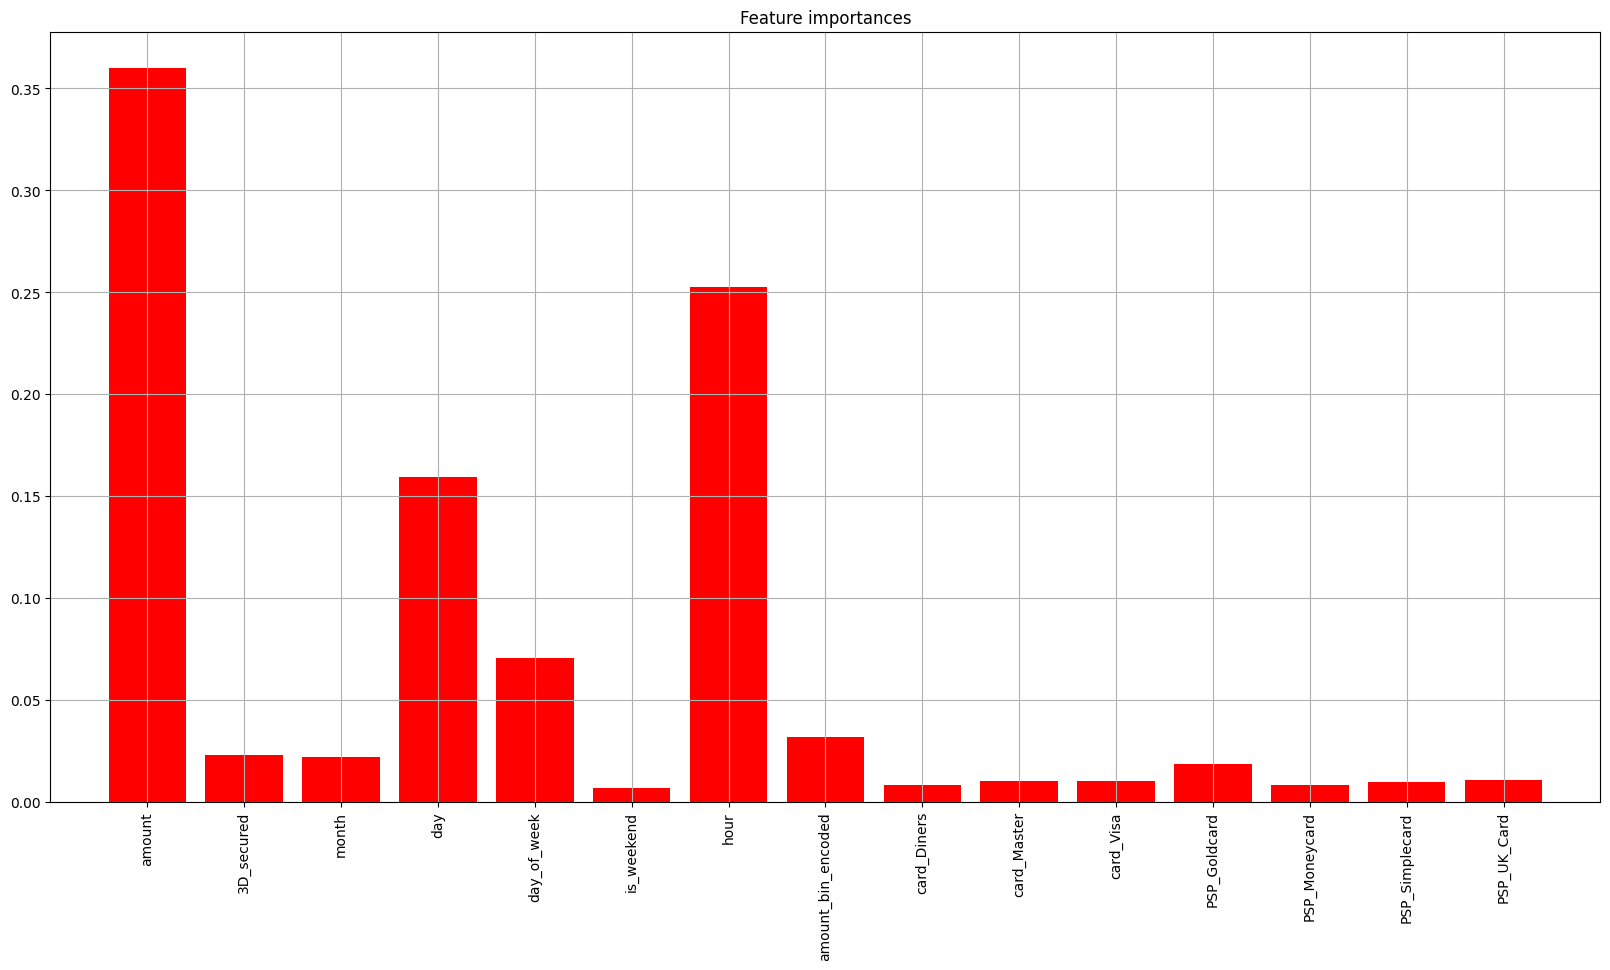

In [79]:
# Plot feature importances
plt.figure(figsize=(20, 10))  # Change figure size
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances, color="r", align="center")
plt.xticks(range(X.shape[1]), X_train.columns, rotation=90)  # Rotate x-axis labels
plt.xlim([-1, X.shape[1]])
plt.grid()
plt.show()

In [80]:
def prediction_baseline_random_forest(input_):
    """
    This function takes a DataFrame as input, performs feature engineering, and makes predictions using a pre-trained
    RandomForestClassifier (rfc). It returns the minimum payment service provider (psp) based on cost and prediction.

    :param input_: DataFrame with columns for "Unnamed: 0", "country", 'amount', '3D-secured', 'tmsp', and 'card'
    :return: Minimum cost psp based on the predictions
    """
    
    # List of cards and psp, and the cost of each psp
    list_card = ['card_Diners', 'card_Master', 'card_Visa']
    list_psp = ['Goldcard', 'Moneycard', 'Simplecard', 'UK_Card']
    cost_psp = {'Goldcard': 10.0, 'Moneycard': 5.0, 'Simplecard': 1.0, 'UK_Card': 3.0}
    
    # Feature engineering
    input_['month'] = input_['tmsp'].dt.month  # Extract month from timestamp
    input_['day'] = input_['tmsp'].dt.day  # Extract day from timestamp
    input_['day_of_week'] = input_['tmsp'].dt.dayofweek  # Extract day of the week from timestamp
    # Create a binary variable indicating whether the day is a weekend
    input_['is_weekend'] = (input_['tmsp'].dt.weekday >= 5).astype(int)  
    input_['hour'] = input_['tmsp'].dt.hour  # Extract hour from timestamp
    
    # Bin 'amount' into 4 quantiles and label encode it
    input_['amount_bin'] = pd.qcut(input_['amount'], q=4)
    le = LabelEncoder()
    input_['amount_bin_encoded'] = le.fit_transform(input_['amount_bin'])
    
    # Initialize each card column to 0
    for card in list_card:
        input_[card] = 0
        
    # Set the corresponding card column to 1 based on the 'card' value
    for index, card in enumerate(input_['card']):
        input_.loc[index, "card_"+card] = 1
        
    # Drop unnecessary columns
    input_ = input_.drop(["Unnamed: 0", "tmsp", "country", "amount_bin", "card"], axis=1)
        
    # Initialize the psp columns to 0
    for psp in list_psp:
        input_["PSP_"+psp] = 0
  
    dict_prediction = {}
      
    # Loop through each row in the input DataFrame
    for j in input_.index:
        
        list_prediction = []
        
        # Loop through each psp
        for i, psp in enumerate(list_psp): 
            
            # For the first psp, make a prediction and store the psp if prediction is 1
            if i == 0:
                input_.loc[j, "PSP_"+psp] = 1
                last_psp = psp
                prediction = rfc.predict(input_.loc[[j]])
                if prediction[0] == 1:
                    list_prediction.append(psp)

                
            # For the subsequent psp, reset the last psp to 0, make a prediction for the current psp, and store the psp if prediction is 1
            elif i > 0:
                input_.loc[j, "PSP_"+last_psp] = 0
                input_.loc[j, "PSP_"+psp] = 1
                prediction = rfc.predict(input_.loc[[j]])
                last_psp = psp
                if prediction[0] == 1:
                    list_prediction.append(psp)
        
        # If no psp has been predicted, default to "Simplecard"
        if list_prediction == []:
            list_prediction.append("Simplecard")
        
        #print(list_prediction)
            
        #print(dict_prediction)
        # Find the psp with the minimum cost from the list of predicted psp
        min_psp = min(list_prediction, key=cost_psp.get)
        
        # Store the minimum cost psp for the current row
        dict_prediction[j] = min_psp

    # Return a dictionary mapping each row index to the minimum cost psp
    return dict_prediction              

In [81]:
# test the function
# test data
data = {
    'country': ['Visa', 'Master', 'Visa', 'Goldcard', 'Visa'],
    'Unnamed: 0': ['Visa', 'Master', 'Visa', 'Goldcard', 'Visa'],
    'amount': [1200, 250, 1750, 3000, 1500],
    '3D_secured': [1, 0, 1, 1, 0],
    'tmsp': [datetime(2023, 1, 1, 11, 30),
             datetime(2023, 2, 15, 13, 45),
             datetime(2023, 3, 3, 16, 0),
             datetime(2023, 4, 20, 19, 15),
             datetime(2023, 5, 25, 9, 45)],
    'card': ['Visa', 'Master', 'Visa', 'Diners', 'Master']
}

df = pd.DataFrame(data)

print(prediction_baseline_random_forest(df))

{0: 'Goldcard', 1: 'Simplecard', 2: 'Goldcard', 3: 'Simplecard', 4: 'Simplecard'}


## 2. Precise Prediction Model

### 2.1. Random Forest with Hyperparameter Tuning

In [82]:
rfc2 = RandomForestClassifier()

In [83]:
# Define the parameters for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [84]:
# Create the grid search
CV_rfc = GridSearchCV(estimator=rfc2, param_grid=param_grid, cv=5, scoring='f1_weighted')

In [85]:
# Run the grid search on the training data
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring='f1_weighted')

In [86]:
# Print the best parameters
print("Best parameters: ", CV_rfc.best_params_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 50}


In [87]:
# Use the model with the best parameters to make predictions on the test set
rfc_best = CV_rfc.best_estimator_
y_pred = rfc_best.predict(X_test)

In [88]:
# Print the precision of the optimized model
print("Optimized model precision: ", precision_score(y_test, y_pred, average='weighted'))

Optimized model precision:  0.7675452040366679


In [89]:
# Predict probabilities on the test set
y_pred_proba = CV_rfc.predict_proba(X_test)

In [102]:
# claculate the mean between the predict probabilities on the test set for the tuned random forest
# extract the arrays for the classes
class_1_probabilities = y_pred_proba[:, 1]
class_0_probabilities = y_pred_proba[:, 0]

# calculate the delta
deltas = class_0_probabilities-class_1_probabilities

# calculate the mean
mean_delta = deltas.mean()

print("The mean delta for the predict probabilities: ", mean_delta)

The mean delta for the predict probabilities:  0.5905239110928395


In [103]:
# Create a DataFrame for easier plotting
proba_df = pd.DataFrame(y_pred_proba, columns=["Probability Not Successful", "Probability Successful"])

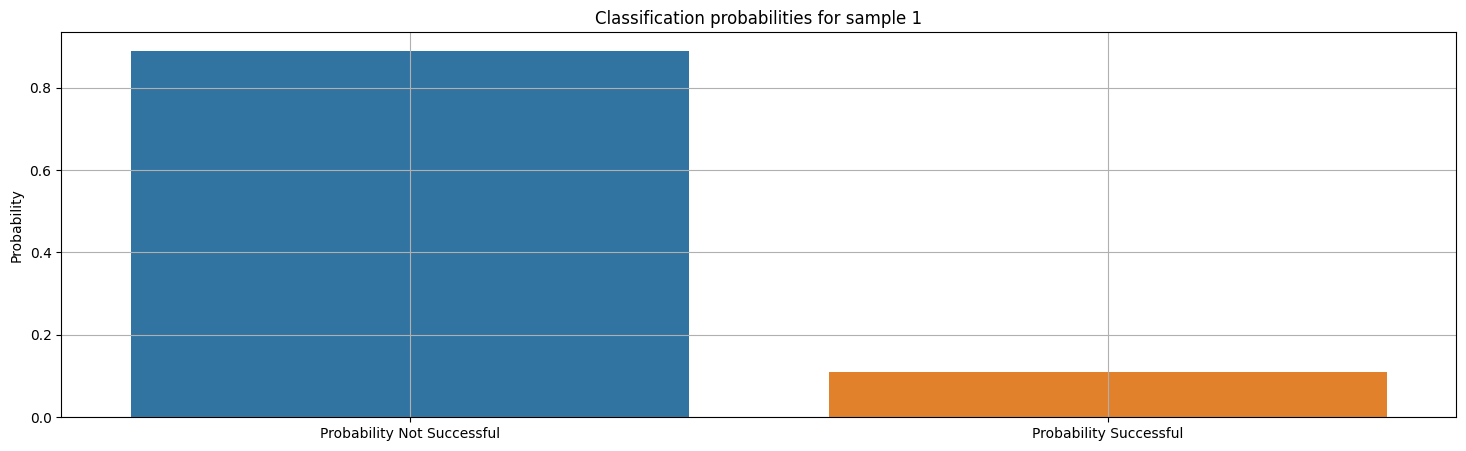

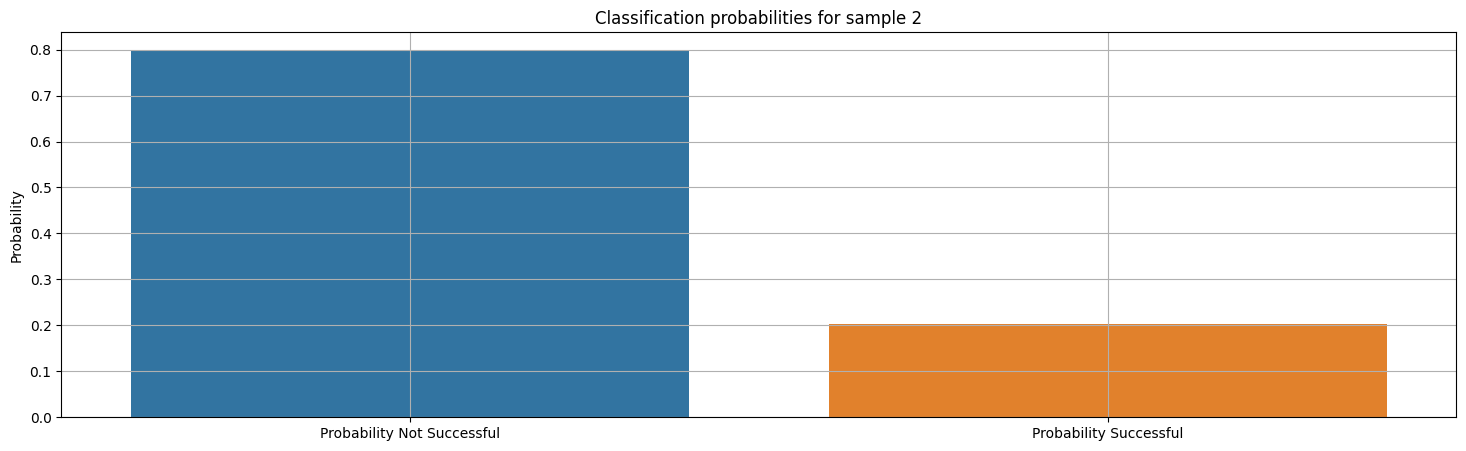

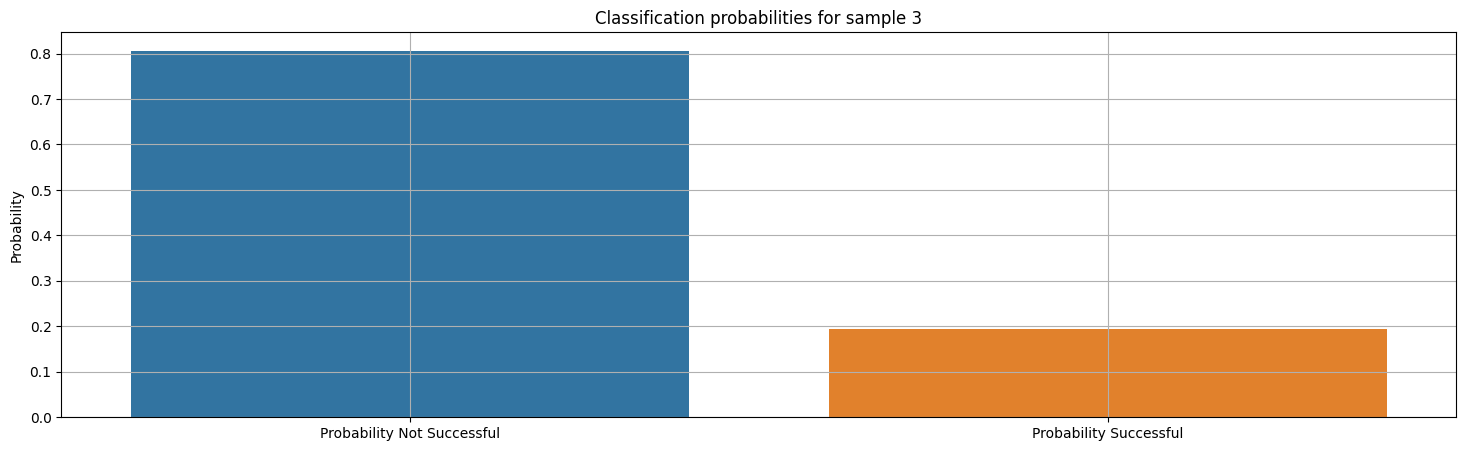

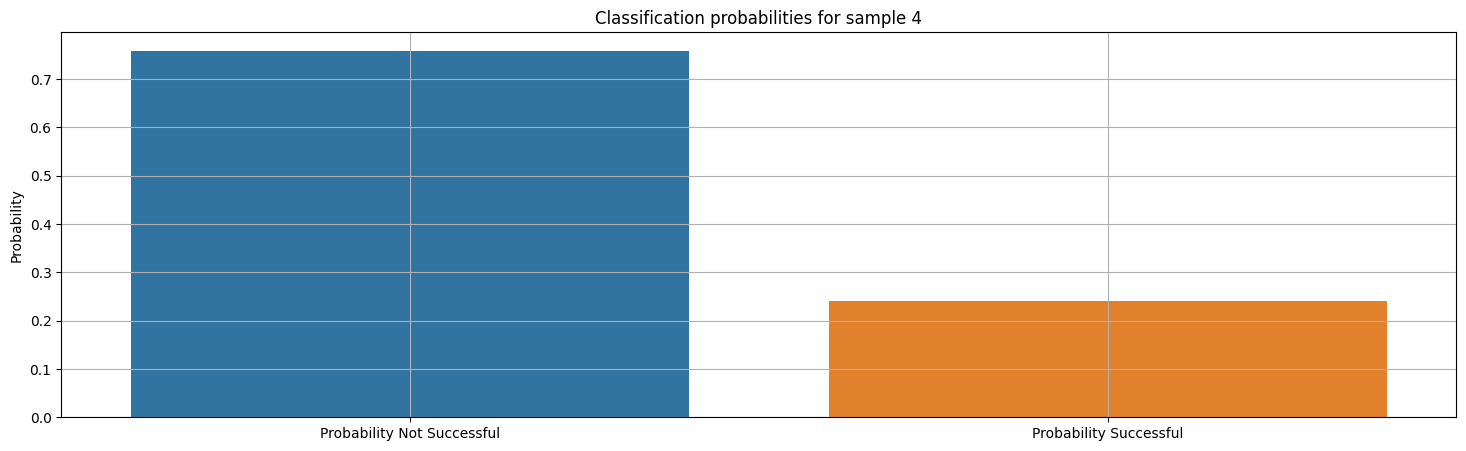

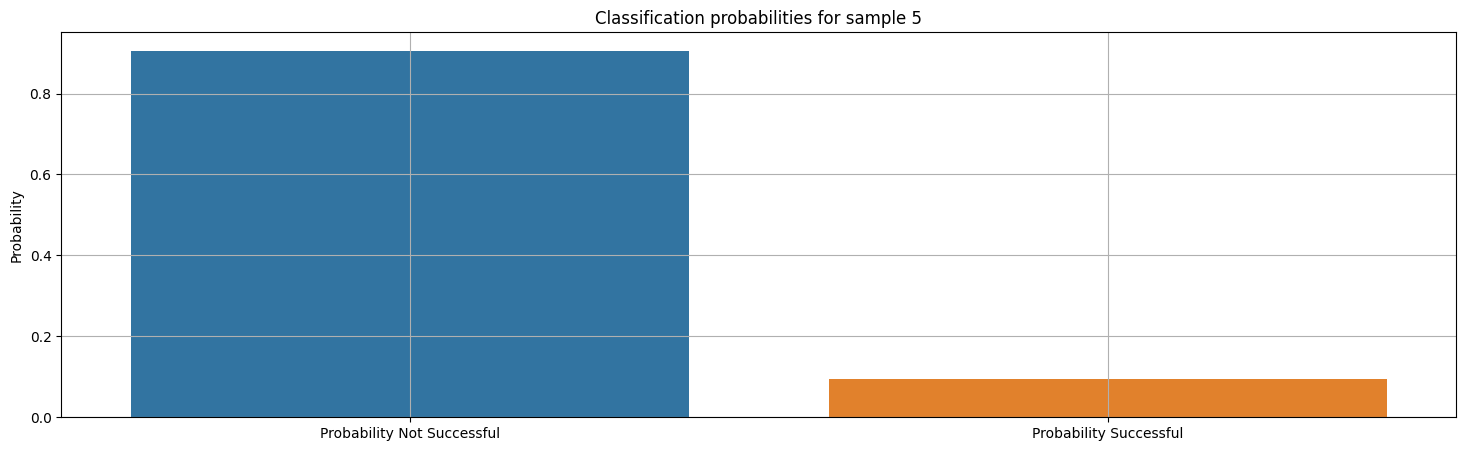

In [104]:
# Plot the classification probabilities for the first few samples in the test set
for i in range(5):
    plt.figure(figsize=(18, 5))
    sns.barplot(x=proba_df.columns, y=proba_df.iloc[i])
    plt.title(f"Classification probabilities for sample {i+1}")
    plt.ylabel("Probability")
    plt.grid()
    plt.show()

In [105]:
# Get feature importances difference
importances_update = CV_rfc.best_estimator_.feature_importances_
difference = np.around((importances_update - importances), 4)

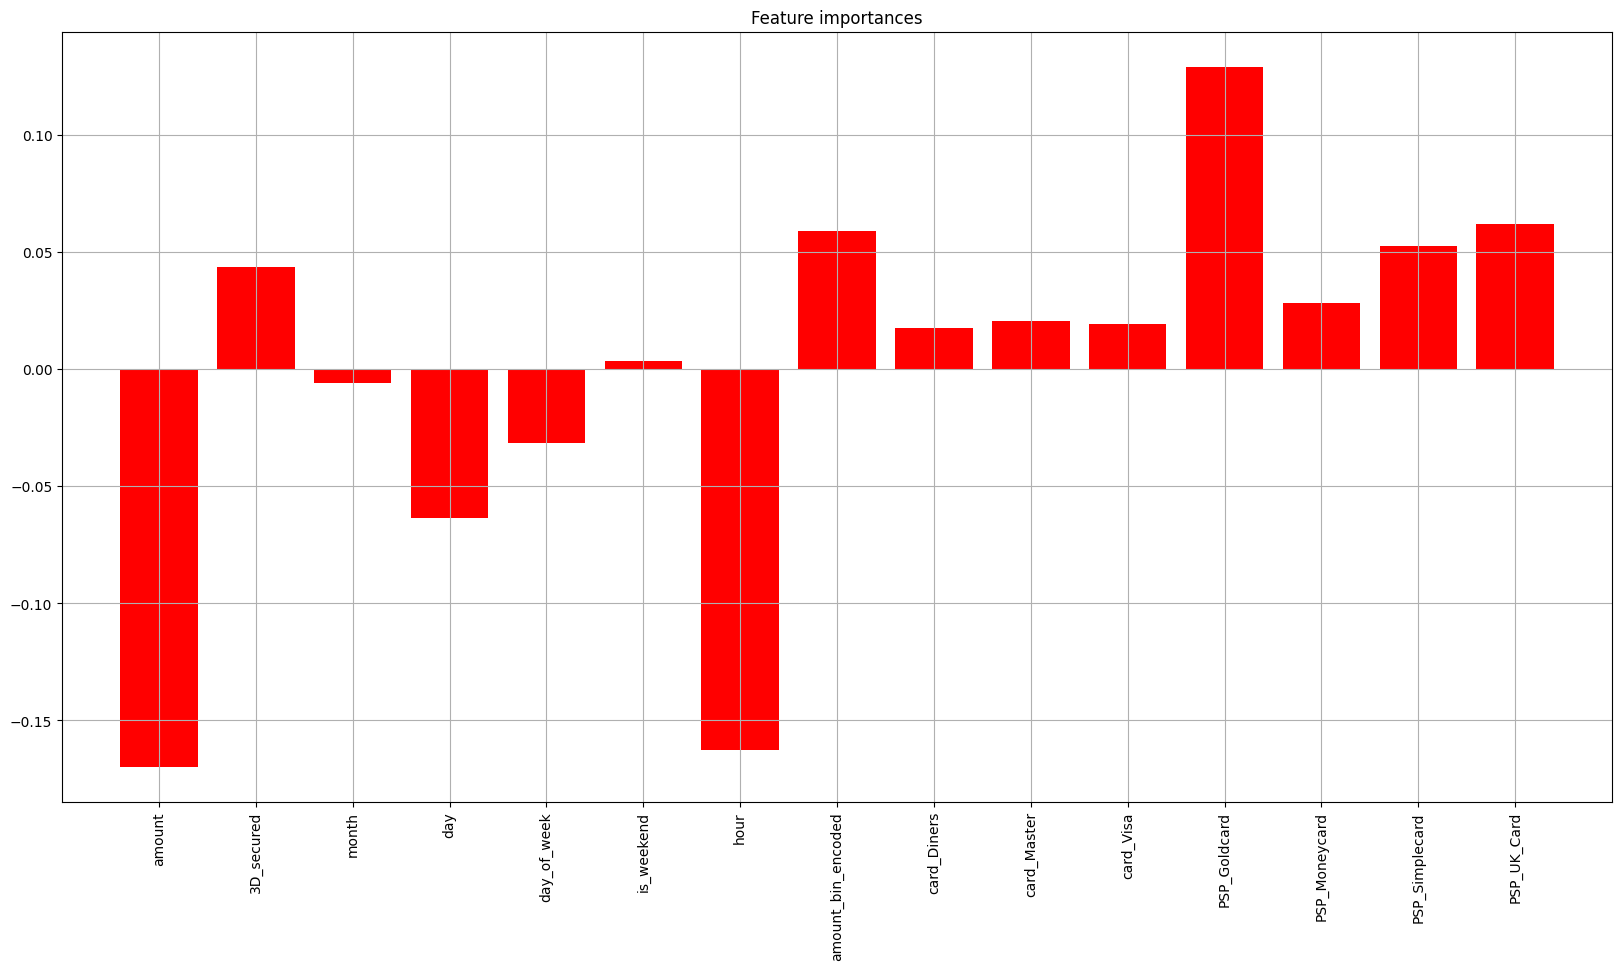

In [106]:
# Plot feature importances
plt.figure(figsize=(20, 10))  # Change figure size
plt.title("Feature importances")
plt.bar(range(X.shape[1]), difference, color="r", align="center")
plt.xticks(range(X.shape[1]), X_train.columns, rotation=90)  # Rotate x-axis labels
plt.xlim([-1, X.shape[1]])
plt.grid()
plt.show()

In [107]:
def prediction_opti_random_forest(input_):
    """
    This function takes a DataFrame as input, performs feature engineering, and makes predictions using a pre-trained
    RandomForestClassifier (rfc). It returns the minimum payment service provider (psp) based on cost and prediction.

    :param input_: DataFrame with columns for "Unnamed: 0", "country", 'amount', '3D-secured', 'tmsp', and 'card'
    :return: Minimum cost psp based on the predictions
    """
    
    # List of cards and psp, and the cost of each psp
    list_card = ['card_Diners', 'card_Master', 'card_Visa']
    list_psp = ['Goldcard', 'Moneycard', 'Simplecard', 'UK_Card']
    cost_psp = {'Goldcard': 10.0, 'Moneycard': 5.0, 'Simplecard': 1.0, 'UK_Card': 3.0}
    
    # Feature engineering
    input_['month'] = input_['tmsp'].dt.month  # Extract month from timestamp
    input_['day'] = input_['tmsp'].dt.day  # Extract day from timestamp
    input_['day_of_week'] = input_['tmsp'].dt.dayofweek  # Extract day of the week from timestamp
    # Create a binary variable indicating whether the day is a weekend
    input_['is_weekend'] = (input_['tmsp'].dt.weekday >= 5).astype(int)  
    input_['hour'] = input_['tmsp'].dt.hour  # Extract hour from timestamp
    
    # Bin 'amount' into 4 quantiles and label encode it
    input_['amount_bin'] = pd.qcut(input_['amount'], q=4)
    le = LabelEncoder()
    input_['amount_bin_encoded'] = le.fit_transform(input_['amount_bin'])
    
    # Initialize each card column to 0
    for card in list_card:
        input_[card] = 0
        
    # Set the corresponding card column to 1 based on the 'card' value
    for index, card in enumerate(input_['card']):
        input_.loc[index, "card_"+card] = 1
        
    # Drop unnecessary columns
    input_ = input_.drop(["Unnamed: 0", "tmsp", "country", "amount_bin", "card"], axis=1)
        
    # Initialize the psp columns to 0
    for psp in list_psp:
        input_["PSP_"+psp] = 0
  
    dict_prediction = {}
      
    # Loop through each row in the input DataFrame
    for j in input_.index:
        
        list_prediction = []
        
        # Loop through each psp
        for i, psp in enumerate(list_psp): 
            
            # For the first psp, make a prediction and store the psp if prediction is 1
            if i == 0:
                input_.loc[j, "PSP_"+psp] = 1
                last_psp = psp
                prediction = rfc_best.predict(input_.loc[[j]])
                if prediction[0] == 1:
                    list_prediction.append(psp)

                
            # For the subsequent psp, reset the last psp to 0, make a prediction for the current psp, and store the psp if prediction is 1
            elif i > 0:
                input_.loc[j, "PSP_"+last_psp] = 0
                input_.loc[j, "PSP_"+psp] = 1
                prediction = rfc_best.predict(input_.loc[[j]])
                last_psp = psp
                if prediction[0] == 1:
                    list_prediction.append(psp)
        
        # If no psp has been predicted, default to "Simplecard"
        if list_prediction == []:
            list_prediction.append("Simplecard")
        
        #print(list_prediction)
            
        #print(dict_prediction)
        # Find the psp with the minimum cost from the list of predicted psp
        min_psp = min(list_prediction, key=cost_psp.get)
        
        # Store the minimum cost psp for the current row
        dict_prediction[j] = min_psp

    # Return a dictionary mapping each row index to the minimum cost psp
    return dict_prediction

In [108]:
# test the function
# test data
data = {
    'country': ['Visa', 'Master', 'Visa', 'Goldcard', 'Visa'],
    'Unnamed: 0': ['Visa', 'Master', 'Visa', 'Goldcard', 'Visa'],
    'amount': [1200, 250, 1750, 3000, 1500],
    '3D_secured': [1, 0, 1, 1, 0],
    'tmsp': [datetime(2023, 1, 1, 11, 30),
             datetime(2023, 2, 15, 13, 45),
             datetime(2023, 3, 3, 16, 0),
             datetime(2023, 4, 20, 19, 15),
             datetime(2023, 5, 25, 9, 45)],
    'card': ['Visa', 'Master', 'Visa', 'Diners', 'Master']
}

df = pd.DataFrame(data)

print(prediction_opti_random_forest(df))

{0: 'Simplecard', 1: 'Simplecard', 2: 'Goldcard', 3: 'Goldcard', 4: 'Simplecard'}


### 2.2. Gradient Boosting with Hyperparameter Tuning

In [109]:
# Initialize the classifier
clf = GradientBoostingClassifier(random_state=42)

In [110]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

In [111]:
# Initialize GridSearchCV
grid_clf = GridSearchCV(clf, param_grid, cv=5, scoring='f1_weighted')

In [112]:
# Fit GridSearchCV
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_weighted')

In [113]:
# Get the best parameters
best_parameters = grid_clf.best_params_

In [114]:
# Print the best parameters
print("Best parameters: ", best_parameters)

Best parameters:  {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 300}


In [115]:
# Get the best estimator
clf_best = grid_clf.best_estimator_

In [116]:
# Predict the target on the test data
predictions = clf_best.predict(X_test)

In [117]:
# Print Precision
print("Test F1-Score: ", f1_score(y_test, predictions, average='weighted'))

Test F1-Score:  0.7468296289939829


In [126]:
# Predict probabilities on the test set
y_pred_proba = clf_best.predict_proba(X_test)

In [127]:
# claculate the mean between the predict probabilities on the test set for the tuned gradient boosting
# extract the arrays for the classes
class_1_probabilities = y_pred_proba[:, 1]
class_0_probabilities = y_pred_proba[:, 0]

# calculate the delta
deltas = class_0_probabilities-class_1_probabilities

# calculate the mean
mean_delta = deltas.mean()

print("The mean delta for the predict probabilities: ", mean_delta)

The mean delta for the predict probabilities:  0.5926112877537548


In [120]:
# Create a DataFrame for easier plotting
proba_df = pd.DataFrame(y_pred_proba, columns=["Probability Not Successful", "Probability Successful"])

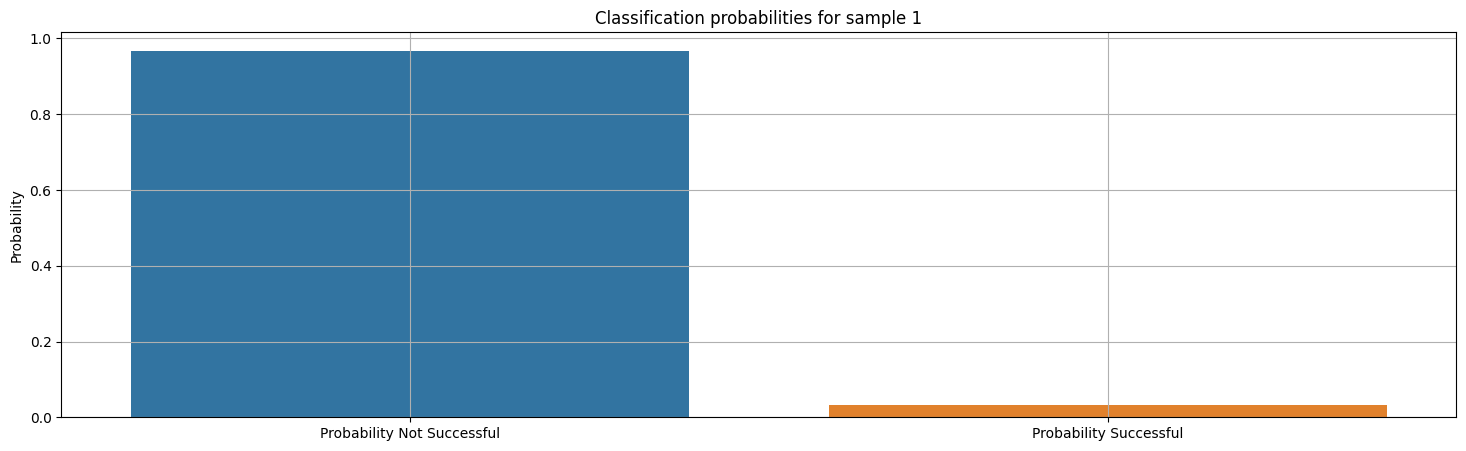

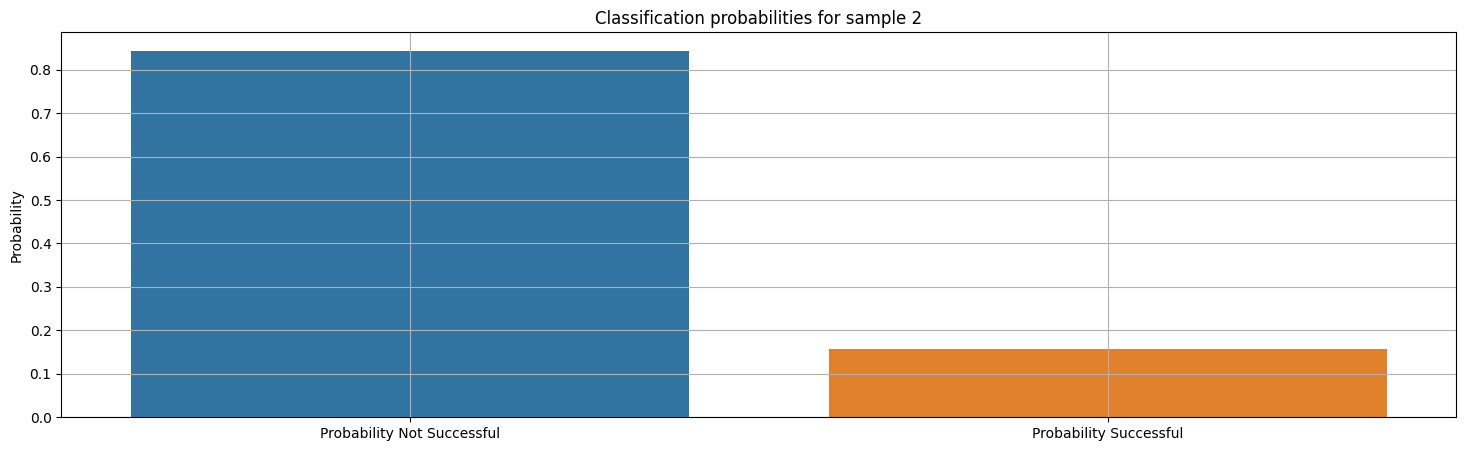

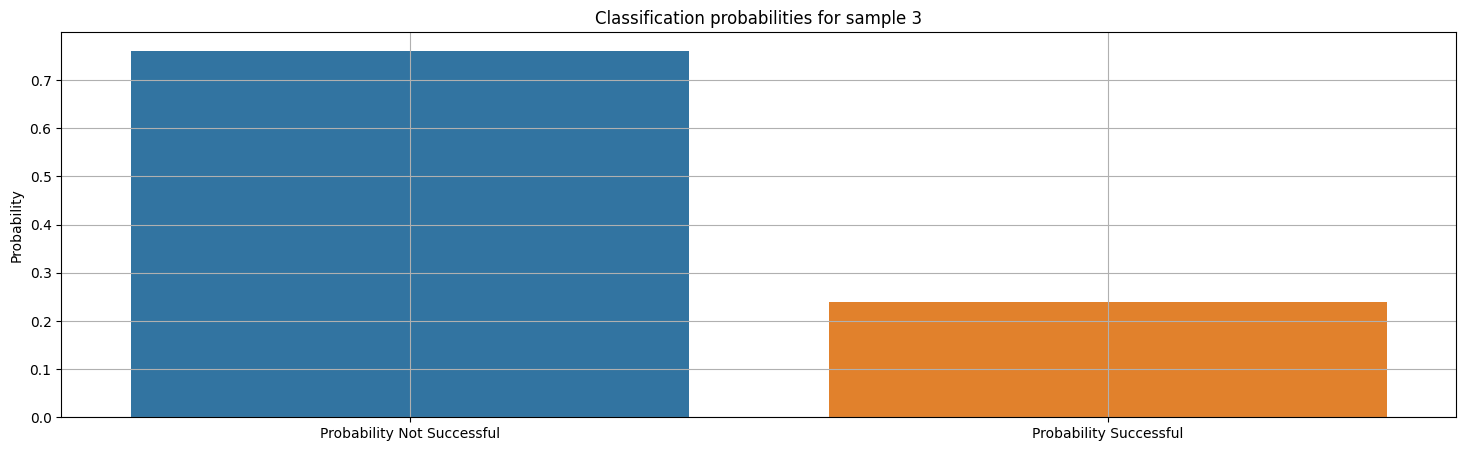

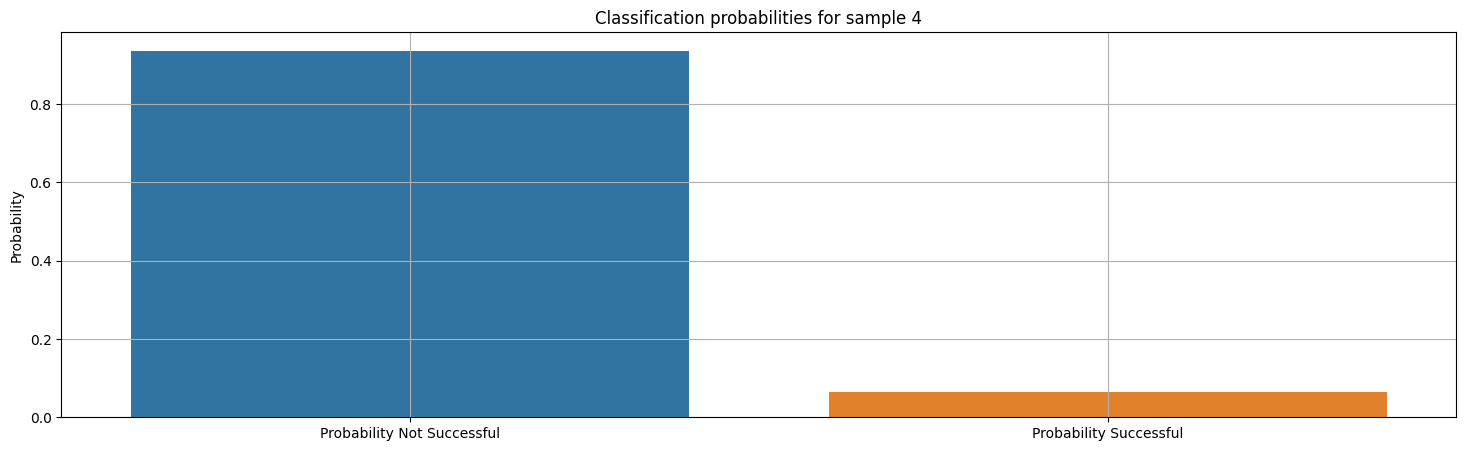

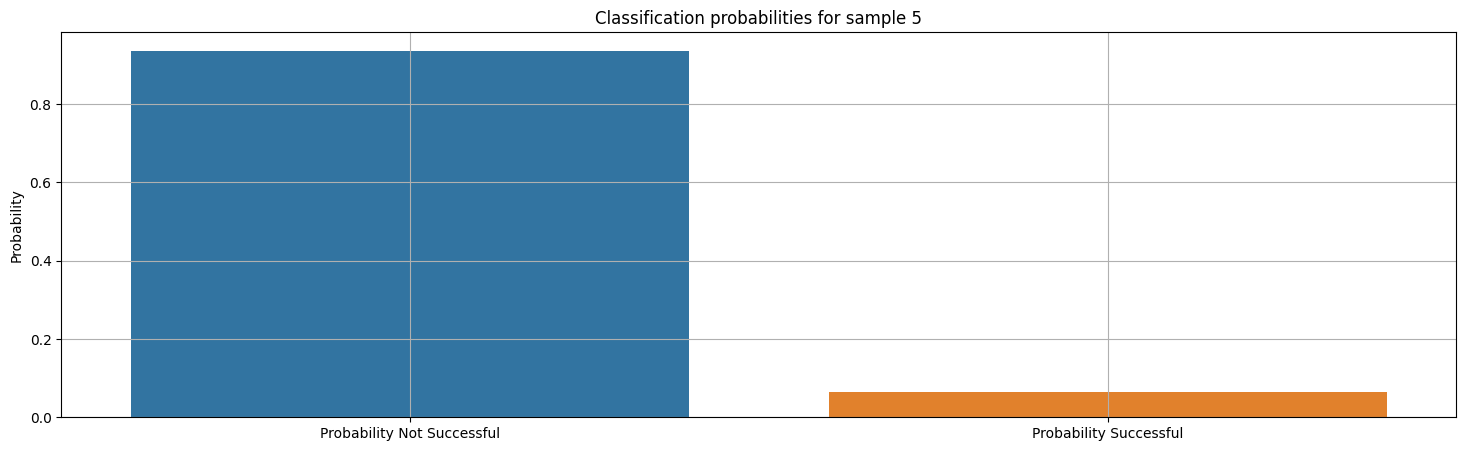

In [121]:
# Plot the classification probabilities for the first few samples in the test set
for i in range(5):
    plt.figure(figsize=(18, 5))
    sns.barplot(x=proba_df.columns, y=proba_df.iloc[i])
    plt.title(f"Classification probabilities for sample {i+1}")
    plt.ylabel("Probability")
    plt.grid()
    plt.show()

In [122]:
# Get feature importances
importances_update2 = clf_best.feature_importances_
difference = np.around((importances_update2 - importances), 4)

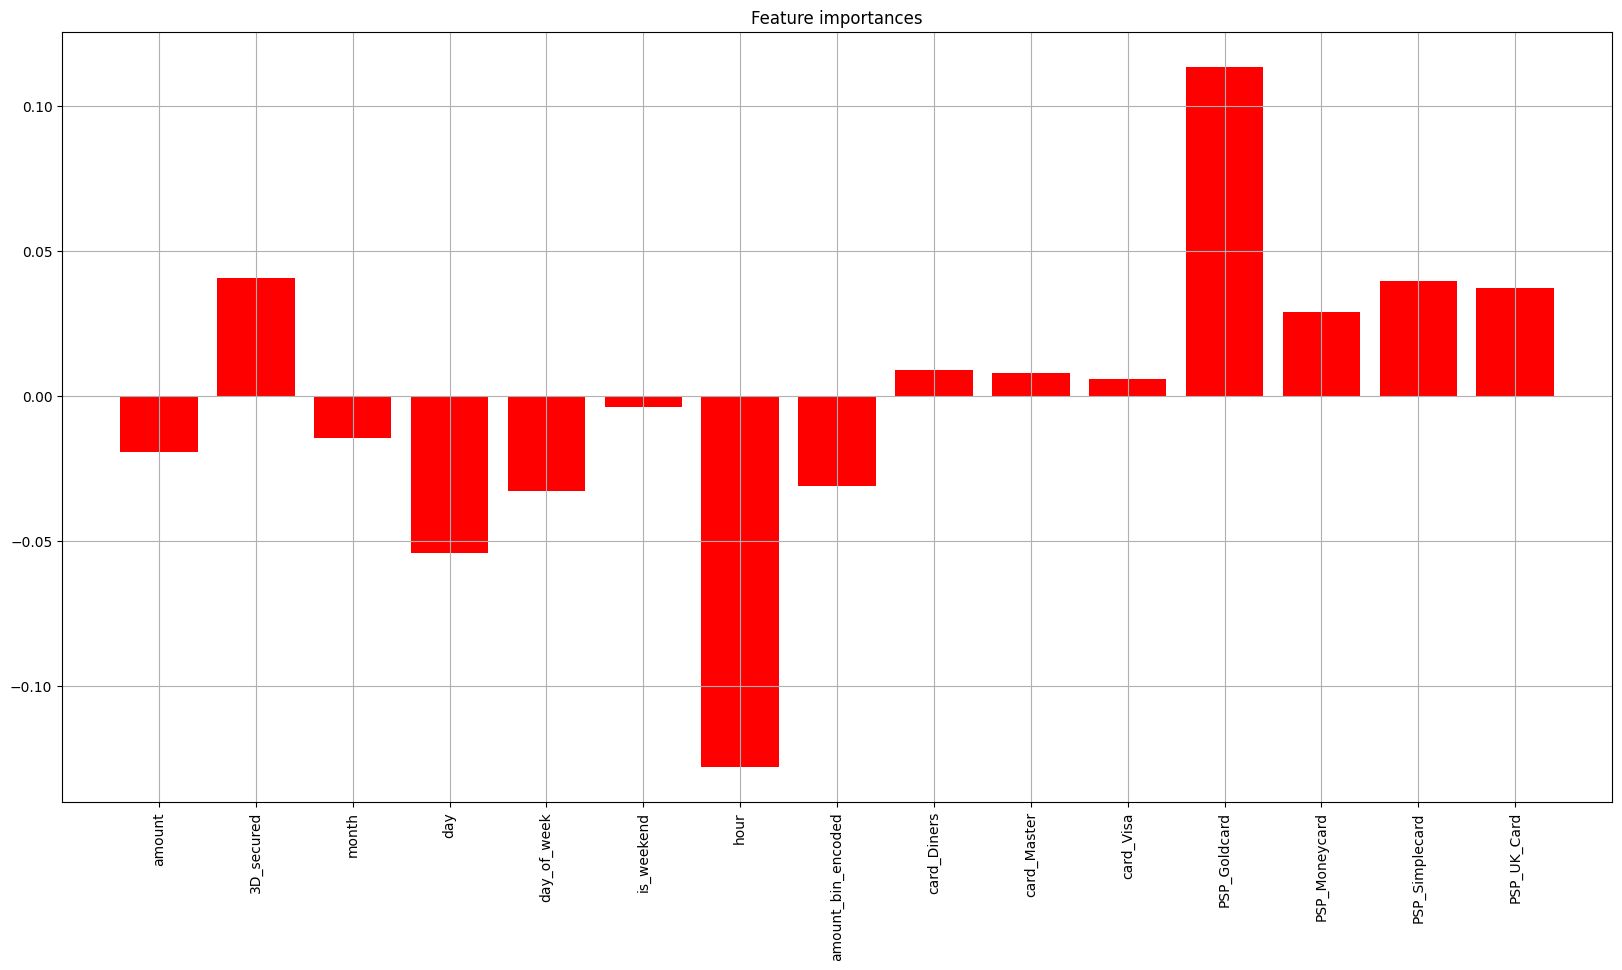

In [123]:
# Plot feature importances
plt.figure(figsize=(20, 10))  # Change figure size
plt.title("Feature importances")
plt.bar(range(X.shape[1]), difference, color="r", align="center")
plt.xticks(range(X.shape[1]), X_train.columns, rotation=90)  # Rotate x-axis labels
plt.xlim([-1, X.shape[1]])
plt.grid()
plt.show()